Start: (0, 0)
Goal: (3, 4)
----------------------------------------
BFS Path Length: 8
BFS Visited Nodes: 19
BFS Time: 7.104873657226562e-05
----------------------------------------
A* Path Length: 8
A* Visited Nodes: 13
A* Time: 7.724761962890625e-05
----------------------------------------
GA Path Length: 11
GA Time: 0.008643865585327148


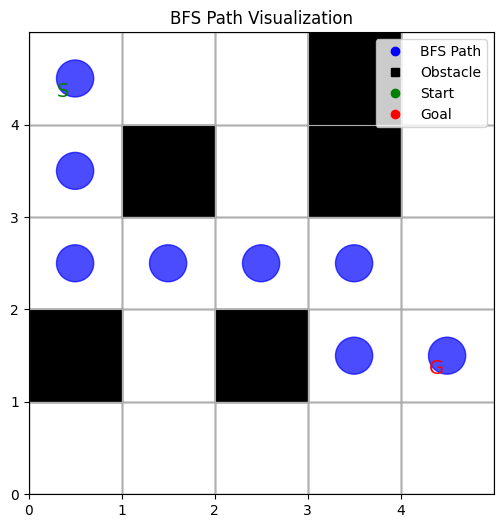

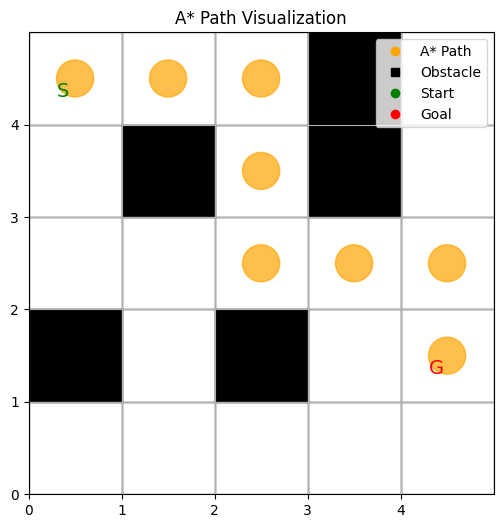

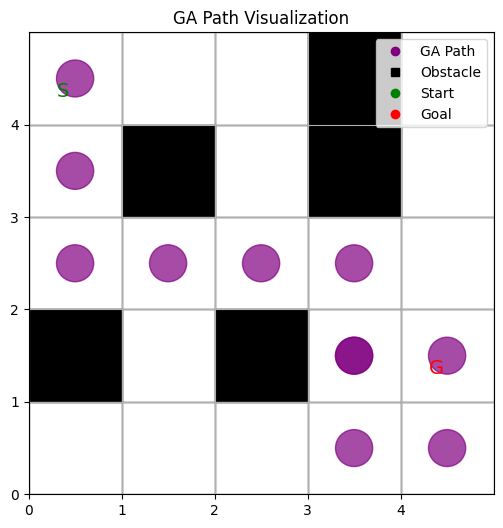

In [12]:
# ===============================
# GOOGLE COLAB COMPATIBLE
# CAR PATH FINDING PROJECT
# BFS – A* – GENETIC ALGORITHM
# WITH VISUALIZATION
# ===============================

%matplotlib inline
import heapq
import random
import time
import matplotlib.pyplot as plt
from collections import deque

# =====================
# GRID DEFINITION
# =====================
grid = [
    ['S', '.', '.', 'X', '.'],
    ['.', 'X', '.', 'X', '.'],
    ['.', '.', '.', '.', '.'],
    ['X', '.', 'X', '.', 'G'],
    ['.', '.', '.', '.', '.']
]

MOVES = [(-1,0), (1,0), (0,-1), (0,1)]

# =====================
# UTILITIES
# =====================
def find_start_goal(grid):
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == 'S':
                start = (i, j)
            elif grid[i][j] == 'G':
                goal = (i, j)
    return start, goal


def is_valid(x, y, grid):
    return (
        0 <= x < len(grid) and
        0 <= y < len(grid[0]) and
        grid[x][y] != 'X'
    )


def reconstruct_path(parent, start, goal):
    path = []
    cur = goal
    while cur != start:
        path.append(cur)
        cur = parent.get(cur)
        if cur is None:
            return []
    path.append(start)
    path.reverse()
    return path

# =====================
# BFS (Uninformed Search)
# =====================
def bfs(grid, start, goal):
    queue = deque([start])
    visited = set([start])
    parent = {}

    while queue:
        x, y = queue.popleft()

        if (x, y) == goal:
            break

        for dx, dy in MOVES:
            nx, ny = x + dx, y + dy
            if is_valid(nx, ny, grid) and (nx, ny) not in visited:
                visited.add((nx, ny))
                parent[(nx, ny)] = (x, y)
                queue.append((nx, ny))

    return reconstruct_path(parent, start, goal), len(visited)

# =====================
# A* (Informed Search)
# =====================
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


def astar(grid, start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))

    g_cost = {start: 0}
    parent = {}
    visited = set()

    while open_set:
        _, current = heapq.heappop(open_set)
        visited.add(current)

        if current == goal:
            break

        for dx, dy in MOVES:
            nx, ny = current[0] + dx, current[1] + dy
            neighbor = (nx, ny)

            if not is_valid(nx, ny, grid):
                continue

            tentative_g = g_cost[current] + 1

            if neighbor not in g_cost or tentative_g < g_cost[neighbor]:
                g_cost[neighbor] = tentative_g
                f = tentative_g + heuristic(neighbor, goal)
                parent[neighbor] = current
                heapq.heappush(open_set, (f, neighbor))

    return reconstruct_path(parent, start, goal), len(visited)

# =====================
# GENETIC ALGORITHM
# =====================
POP_SIZE = 120
PATH_LEN = 30
GENERATIONS = 300


def random_path():
    return [random.choice(MOVES) for _ in range(PATH_LEN)]


def fitness(path, grid, start, goal):
    x, y = start
    score = 0

    for dx, dy in path:
        x += dx
        y += dy

        if not is_valid(x, y, grid):
            return -1000

        score -= 1

        if (x, y) == goal:
            score += 1000
            break

    score -= heuristic((x, y), goal)
    return score


def crossover(p1, p2):
    cut = random.randint(1, PATH_LEN - 2)
    return p1[:cut] + p2[cut:]


def mutate(path, rate=0.05):
    for i in range(len(path)):
        if random.random() < rate:
            path[i] = random.choice(MOVES)
    return path


def genetic_algorithm(grid, start, goal):
    population = [random_path() for _ in range(POP_SIZE)]

    for _ in range(GENERATIONS):
        population.sort(
            key=lambda p: fitness(p, grid, start, goal),
            reverse=True
        )

        if fitness(population[0], grid, start, goal) > 900:
            break

        new_pop = population[:10]

        while len(new_pop) < POP_SIZE:
            p1, p2 = random.sample(population[:30], 2)
            child = crossover(p1, p2)
            new_pop.append(mutate(child))

        population = new_pop

    return population[0]


def ga_path_to_positions(path, start):
    x, y = start
    positions = [start]
    for dx, dy in path:
        x += dx
        y += dy
        if not is_valid(x, y, grid):
            break
        positions.append((x, y))
    return positions

# =====================
# VISUALIZATION
# =====================
def visualize_separate(grid, paths_dict):
    """
    paths_dict: dictionary { 'BFS': path, 'A*': path, 'GA': path }
    """
    colors = {'BFS': 'blue', 'A*': 'orange', 'GA': 'purple'}

    for name, path in paths_dict.items():
        rows, cols = len(grid), len(grid[0])
        fig, ax = plt.subplots(figsize=(6,6))

        # Draw grid
        for x in range(rows):
            for y in range(cols):
                if grid[x][y] == 'X':
                    ax.add_patch(plt.Rectangle((y, rows-x-1), 1, 1, color='black'))
                else:
                    ax.add_patch(plt.Rectangle((y, rows-x-1), 1, 1,
                                               edgecolor='gray', fill=False))
                if grid[x][y] == 'S':
                    ax.text(y+0.3, rows-x-0.7, 'S', fontsize=14, color='green')
                elif grid[x][y] == 'G':
                    ax.text(y+0.3, rows-x-0.7, 'G', fontsize=14, color='red')

        # Draw path
        for (x, y) in path:
            ax.add_patch(
                plt.Circle((y+0.5, rows-x-0.5), 0.2, color=colors[name], alpha=0.7)
            )

        # Legend
        ax.plot([], [], 'o', color=colors[name], label=f'{name} Path')
        ax.plot([], [], 's', color='black', label='Obstacle')
        ax.plot([], [], 'o', color='green', label='Start')
        ax.plot([], [], 'o', color='red', label='Goal')
        ax.legend(loc='upper right')

        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_xticks(range(cols))
        ax.set_yticks(range(rows))
        ax.set_title(f"{name} Path Visualization")
        ax.grid(True)

        # Save and show
        plt.savefig(f"{name}.png")
        plt.show()


# =====================
# MAIN CLASS
# =====================
class Main:
    def run(self):
        start, goal = find_start_goal(grid)

        print("Start:", start)
        print("Goal:", goal)
        print("-" * 40)

        t0 = time.time()
        bfs_path, bfs_visited = bfs(grid, start, goal)
        print("BFS Path Length:", len(bfs_path))
        print("BFS Visited Nodes:", bfs_visited)
        print("BFS Time:", time.time() - t0)
        print("-" * 40)

        t0 = time.time()
        astar_path, astar_visited = astar(grid, start, goal)
        print("A* Path Length:", len(astar_path))
        print("A* Visited Nodes:", astar_visited)
        print("A* Time:", time.time() - t0)
        print("-" * 40)

        t0 = time.time()
        ga_moves = genetic_algorithm(grid, start, goal)
        ga_path = ga_path_to_positions(ga_moves, start)
        print("GA Path Length:", len(ga_path))
        print("GA Time:", time.time() - t0)

        visualize_separate(grid, {
    'BFS': bfs_path,
    'A*': astar_path,
    'GA': ga_path
})



# =====================
# RUN
# =====================
Main().run()
